##### <h1 id="aa" align="center" style="color:black;background:#ffcc01;padding:18px;border-radius:50px"> КЛАСТЕРИЗАЦИЯ ПОКЕМОНОВ </h1> 

# Подключение модулей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score, silhouette_score, mean_absolute_error, r2_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
import scipy.cluster.hierarchy as sch


import warnings
warnings.filterwarnings('ignore')

# Загрузка и просмотр набора данных

In [2]:
df = pd.read_csv('pokemon.csv')
print(df.shape)
df.head(10)

(1045, 8)


,Name,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed
0,Bulbasaur,318,45,49,49,65,65,45
1,Ivysaur,405,60,62,63,80,80,60
2,Venusaur,525,80,82,83,100,100,80
3,Mega Venusaur,625,80,100,123,122,120,80
4,Charmander,309,39,52,43,60,50,65
5,Charmeleon,405,58,64,58,80,65,80
6,Charizard,534,78,84,78,109,85,100
7,Mega Charizard,634,78,130,111,130,85,100
8,Mega Charizard X,634,78,104,78,159,115,100
9,Squirtle,314,44,48,65,50,64,43


# Описание данных

##### Признаки:
- **Name** - Имя каждого покемона.
- **Total** - Сумма всех статистик, которые идут после этого, общее руководство по тому, насколько силен покемон.
- **HP** - Хит-пойнты, или здоровье, определяют, сколько урона может выдержать покемон, прежде чем потеряет сознание.
- **Attack** - Базовый модификатор для обычных атак (например, Царапина, Удар).
- **Defence** - Базовое сопротивление урону от обычных атак.
- **Sp_attack** - специальная атака, базовый модификатор для специальных атак (например, огненный взрыв, луч пузыря).
- **Sp_defence** - базовое сопротивление урону от специальных атак.
- **Speed** - Определяет, какой покемон атакует первым в каждом раунде.


  Целевая переменная - Сумма всех статистик

Эти данные представляют характеристики покемонов. Всего представленно 1045 записей.

In [3]:
# Информация про набор данных
data = pd.DataFrame()

data.index =  df.columns
data['count_NaN'] = df.isna().sum()
data['dtypes'] = df.dtypes
data['uniq'] = df.nunique()
data['shape'] = df.shape[0]
data

,count_NaN,dtypes,uniq,shape
Name,0,object,1035,1045
Total,0,int64,216,1045
HP,0,int64,103,1045
Attack,0,int64,123,1045
Defence,0,int64,114,1045
Sp_attack,0,int64,119,1045
Sp_defence,0,int64,107,1045
Speed,0,int64,127,1045


In [4]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1045 non-null   object
 1   Total       1045 non-null   int64 
 2   HP          1045 non-null   int64 
 3   Attack      1045 non-null   int64 
 4   Defence     1045 non-null   int64 
 5   Sp_attack   1045 non-null   int64 
 6   Sp_defence  1045 non-null   int64 
 7   Speed       1045 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 65.4+ KB


In [5]:
df.duplicated().sum()

np.int64(5)

В данном датасете отсутствуют пропущенные значения, но присутствуют повторяющиеся записи.

Удалим дубликаты.

In [6]:
df=df.drop_duplicates() # Удаляем дубликаты

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Total,1040.0,439.065385,122.179909,175.0,330.0,457.0,515.0,1125.0
HP,1040.0,70.121154,26.713263,1.0,50.0,68.0,83.0,255.0
Attack,1040.0,80.531731,32.477622,5.0,55.0,78.0,100.0,190.0
Defence,1040.0,74.576923,31.263940,5.0,50.0,70.0,90.0,250.0
Sp_attack,1040.0,72.908654,32.748911,10.0,50.0,65.0,95.0,194.0
Sp_defence,1040.0,72.193269,28.079396,20.0,50.0,70.0,90.0,250.0
Speed,1040.0,68.733654,30.259182,5.0,45.0,65.0,90.0,200.0


По данному набору данных аномальных значений не наблюдается.

In [9]:
X=df.iloc[:,1:]
y=df.iloc[:,0]

In [10]:
X

,Total,HP,Attack,Defence,Sp_attack,Sp_defence,Speed
0,318,45,49,49,65,65,45
1,405,60,62,63,80,80,60
2,525,80,82,83,100,100,80
3,625,80,100,123,122,120,80
4,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...
1040,580,100,145,130,65,110,30
1041,580,100,65,60,145,80,130
1042,500,100,80,80,80,80,80
1043,680,100,165,150,85,130,50


### Распределение данных

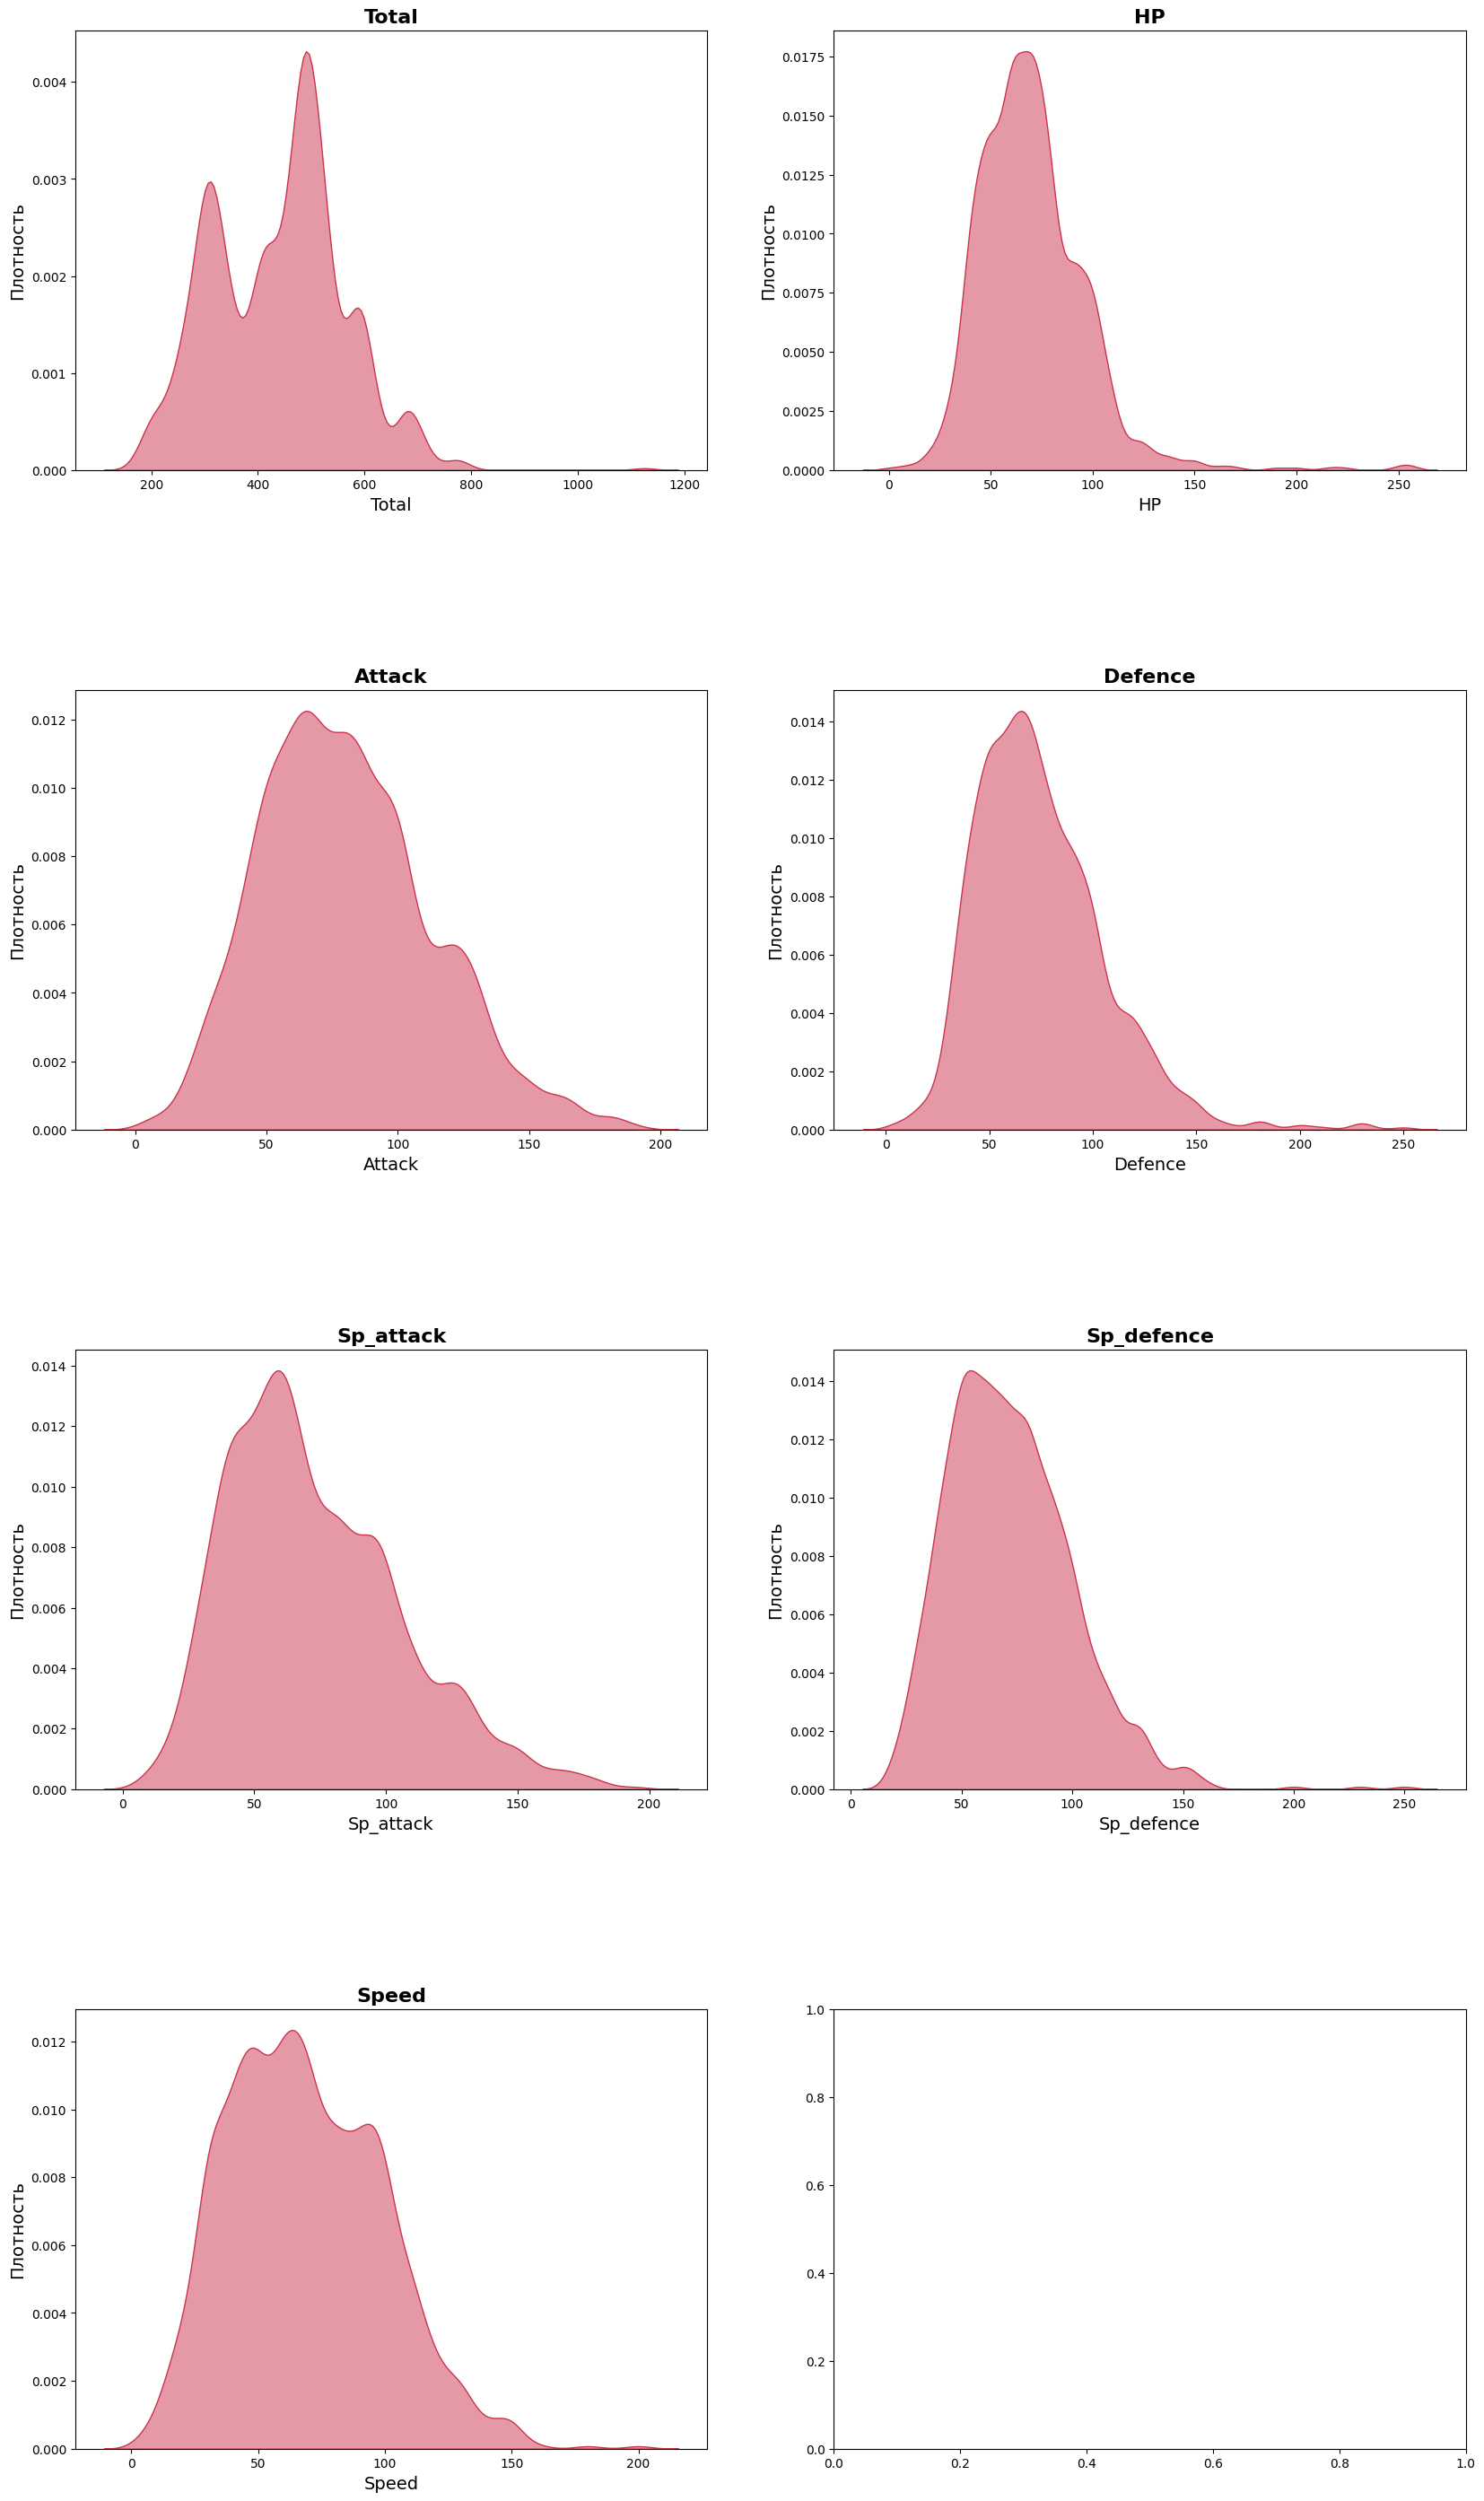

In [11]:
fig, axes = plt.subplots(4, 2, figsize = (20, 35))

plt.subplots_adjust(hspace=0.5)

columns = X.columns

for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = X,
                x = column,
                fill = True,
                alpha = 0.5,
                bw_adjust=.7,
                color = [0.8, 0.2, 0.3],
                ax = ax)
    
    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 14)
    ax.set_ylabel('Плотность', fontsize = 14)
    

plt.show()

### Нормализация

In [12]:
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(X), columns = X.columns)

### Метод главных компонентов

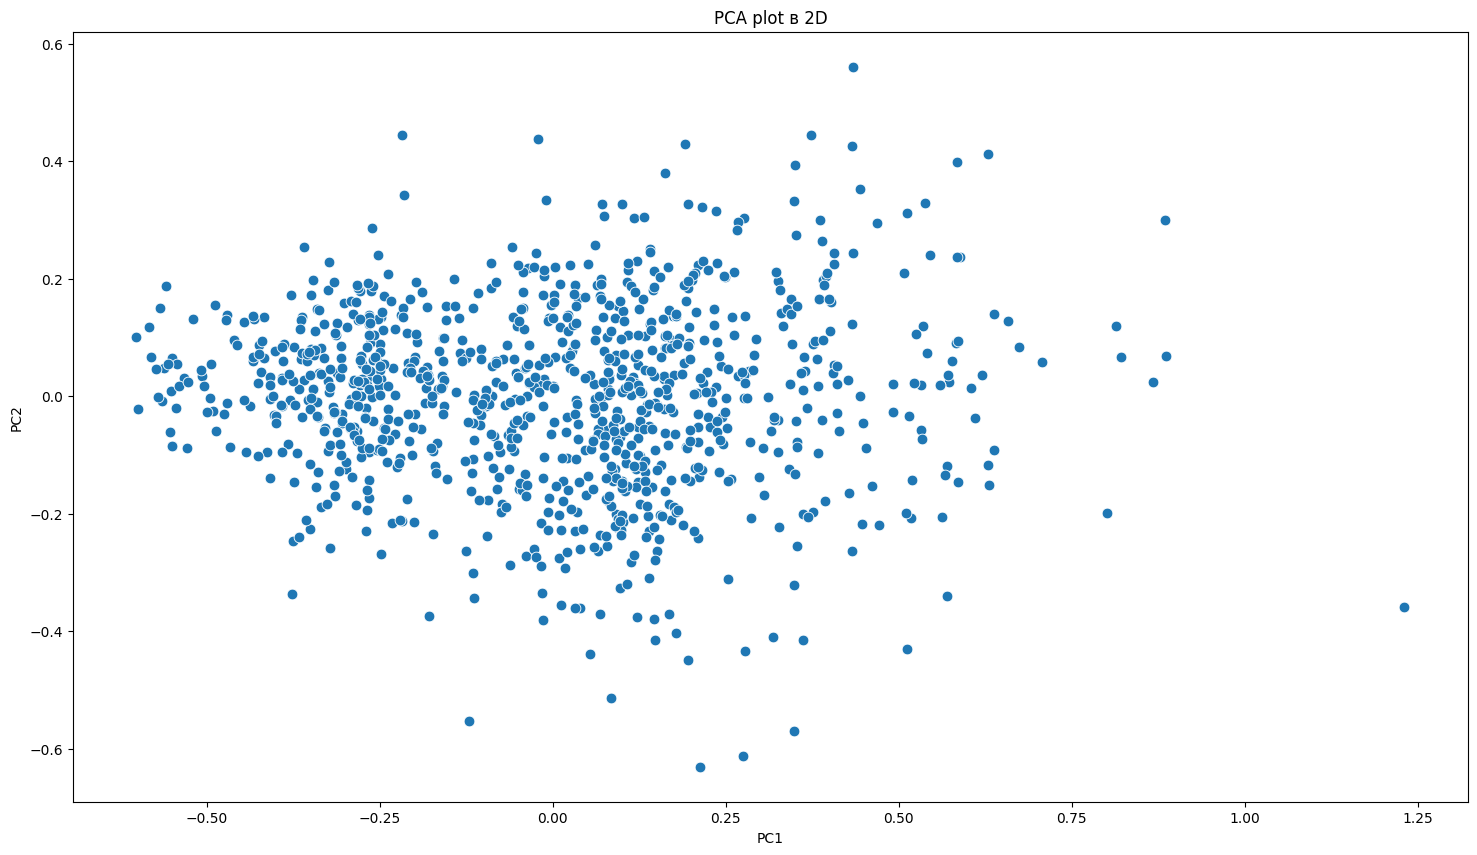

In [13]:
principal_df = pd.DataFrame(data = PCA(n_components = 2).fit_transform(X))
    
fig = plt.figure(figsize = (18, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                s=60)

plt.title('PCA plot в 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

In [14]:
def TSNEplot(pred=None):    
    tsne = TSNE(random_state=1)

    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize = (18, 10))
    plt.scatter(X_tsne[:, 0], 
                X_tsne[:, 1], 
                c = pred, 
                edgecolor = "none", 
                alpha = 0.7, s = 40,
        cmap = plt.cm.get_cmap("flare", 3))

    plt.colorbar()
    plt.title("t-SNE projection");

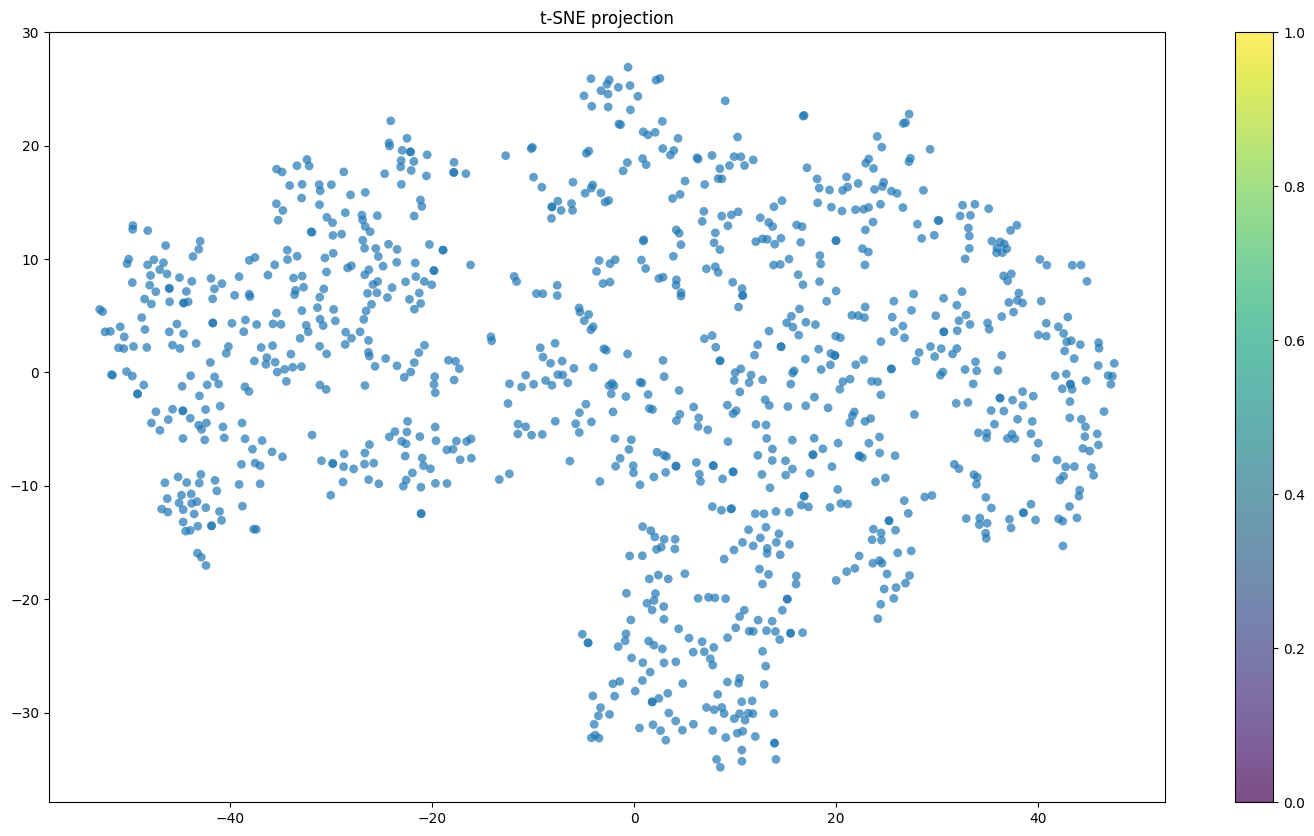

In [15]:
TSNEplot()

In [16]:
def PCAplot3D(x_data, y_data=None):
    components = PCA(n_components = 3).fit_transform(x_data)

    fig = px.scatter_3d(
        components, 
        x = 0, y = 1, z = 2, 
        color = y_data, 
        size = 0.1 * np.ones(len(X)), 
        opacity = 1,
        title = 'PCA plot in 3D',
        labels = {'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        width = 1200, height = 900
    )
    fig.show()

In [17]:
PCAplot3D(X)

### Моделирование

### K-Means

In [18]:
pca = PCA(n_components=2)

kmeans = KMeans(n_clusters = 3, random_state = 42, n_init = 'auto').fit(X)
centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components = 2).fit_transform(X))

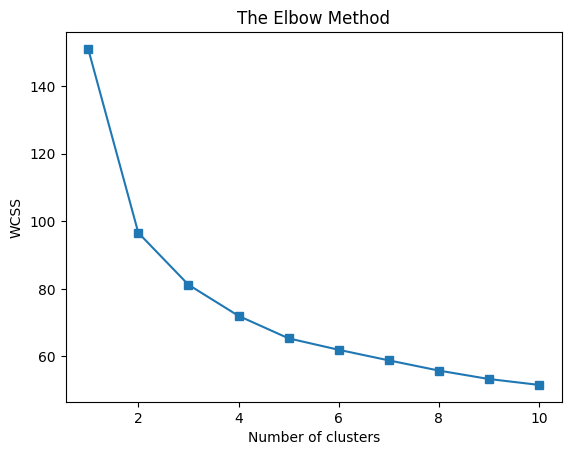

In [19]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42, init = 'k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss, marker = "s")
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [20]:
pca = PCA(n_components = 2)


kmeans = KMeans(n_clusters = 2, n_init = 10, init = 'k-means++')
kmeans.fit(X)

centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components = 2).fit_transform(X))

In [21]:
df["cluster"] = pd.Series(pred_k, dtype='Int8')

In [22]:
scores = []
values = np.arange(2, 10)

In [23]:
for num_clusters in values:
    kmeans = KMeans(init = 'k-means++', n_clusters = num_clusters, n_init = 10)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_, 
                metric = 'euclidean', sample_size = len(X))

    print()
    print("Number of clusters =", num_clusters)
    print("Silhouette score =", score)
                    
    scores.append(score)


Number of clusters = 2
Silhouette score = 0.31229421116627837

Number of clusters = 3
Silhouette score = 0.25440569967437493

Number of clusters = 4
Silhouette score = 0.24848501431389902

Number of clusters = 5
Silhouette score = 0.24622219155244363

Number of clusters = 6
Silhouette score = 0.22200298865484314

Number of clusters = 7
Silhouette score = 0.1681778355032381

Number of clusters = 8
Silhouette score = 0.17059481760135595

Number of clusters = 9
Silhouette score = 0.16091693320601938


Optimal number of clusters = 2


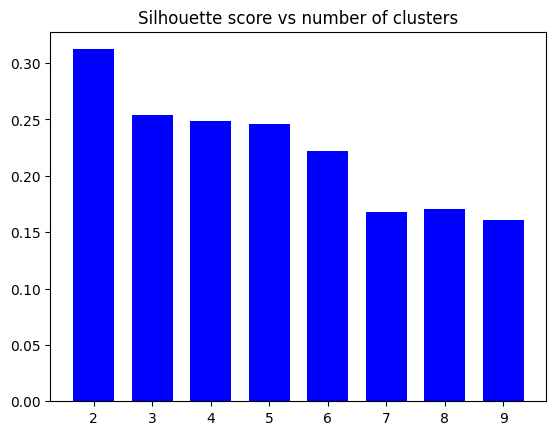

In [24]:
plt.figure()
plt.bar(values, scores, width = 0.7, color = 'blue', align = 'center')
plt.title('Silhouette score vs number of clusters')

num_clusters = np.argmax(scores) + values[0]
print('Optimal number of clusters =', num_clusters)

plt.show()

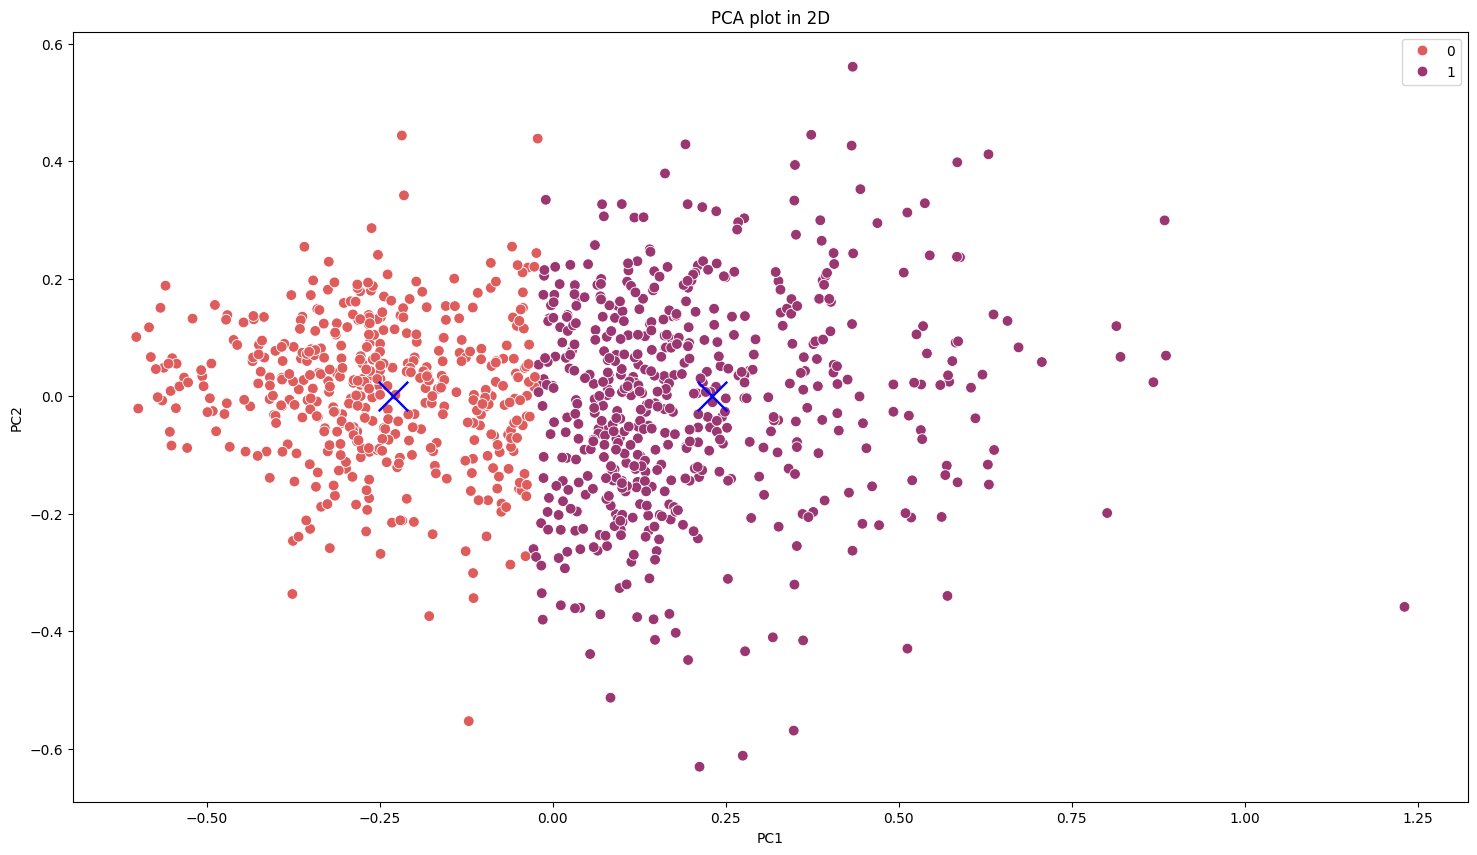

In [25]:
fig = plt.figure(figsize = (18, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_k, 
                palette = "flare", 
                s = 60)
sns.scatterplot(x = centroids_pca[:,0], 
                y =  centroids_pca[:,1],  
                marker = "x", 
                s = 450, 
                color = 'blue')
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

### Agglomerative Clustering by Ward

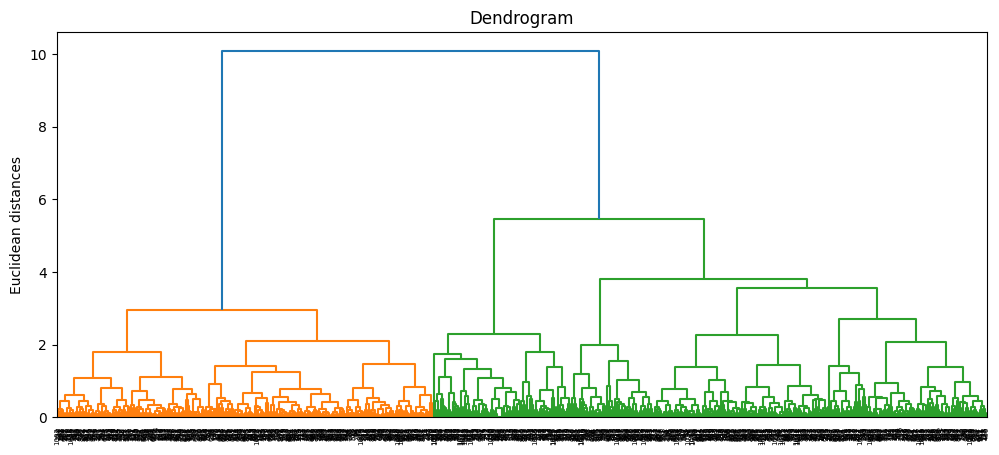

In [26]:
plt.figure(figsize = (12, 5))
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

In [27]:
clustering_ward = AgglomerativeClustering(2).fit(X)
pred_ward = clustering_ward.labels_

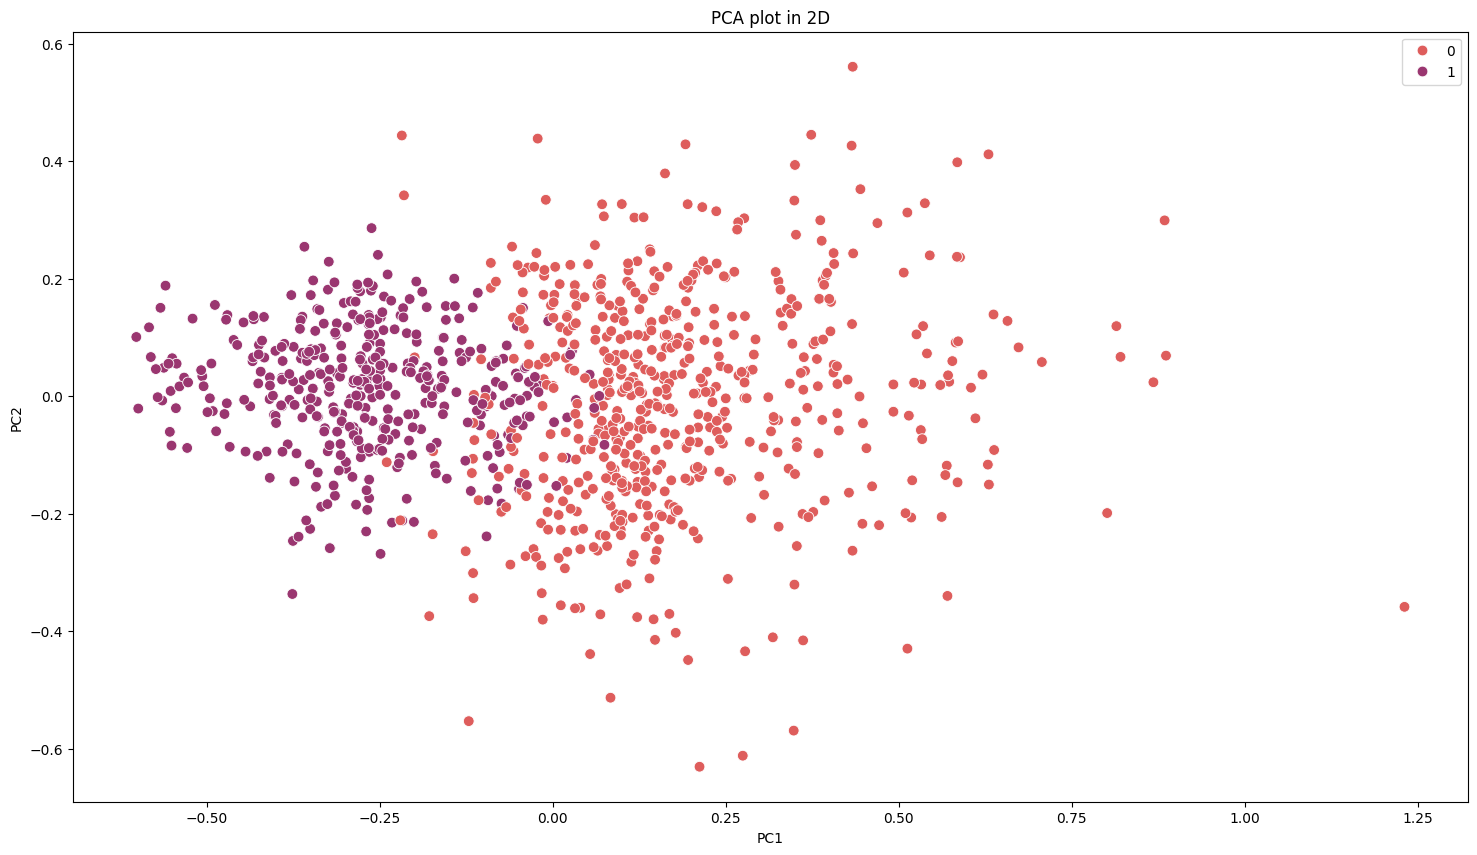

In [28]:
fig = plt.figure(figsize = (18, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_ward, 
                palette = "flare", 
                s = 60)
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

### Spectral Clustering

In [29]:
clustering_sp = SpectralClustering(2).fit(X)
pred_sp = clustering_sp.labels_

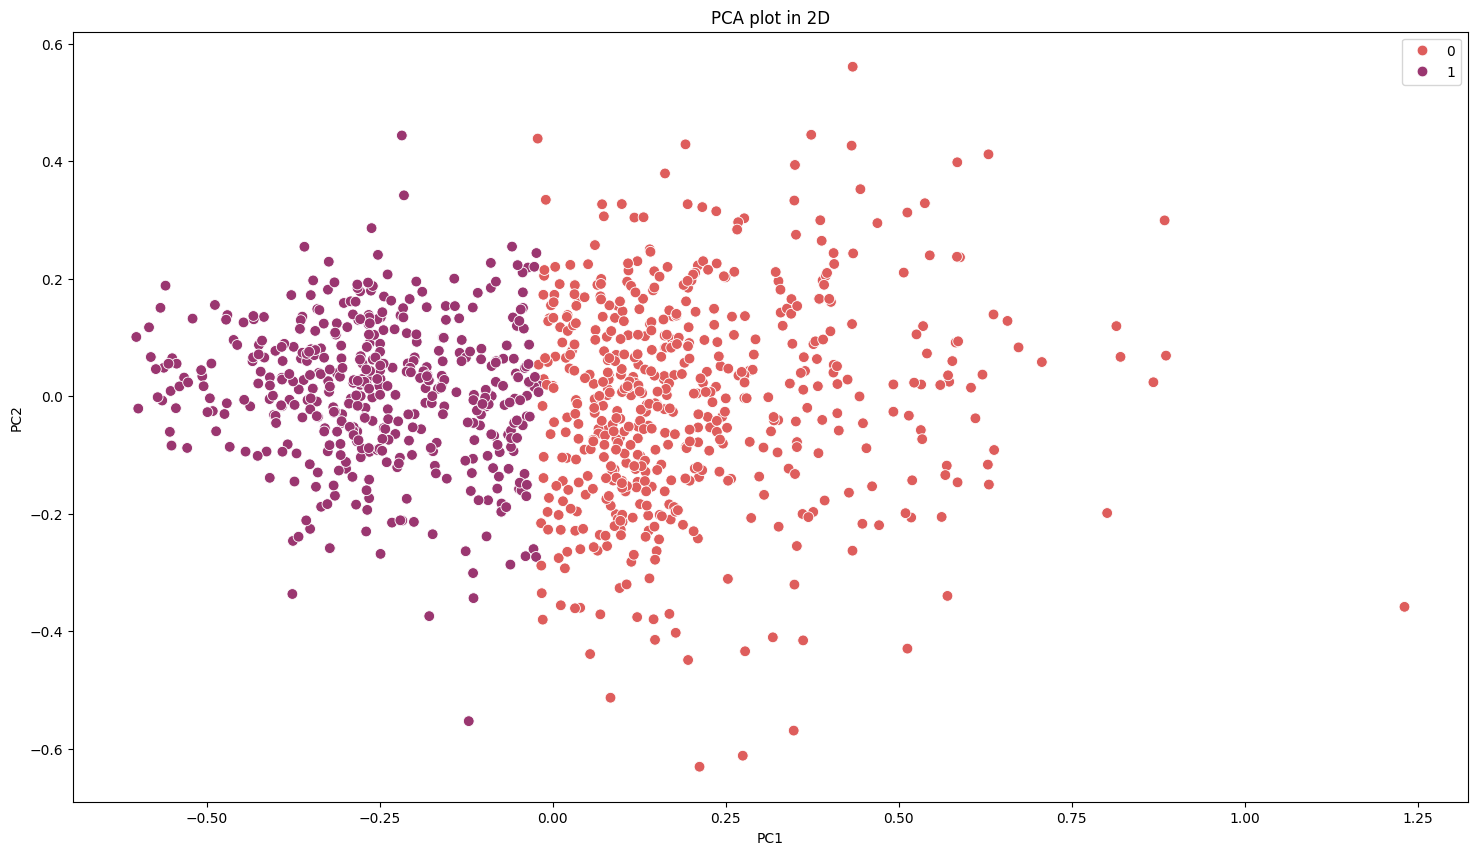

In [30]:
fig = plt.figure(figsize = (18, 10))
sns.scatterplot(x = principal_df.iloc[:,0], 
                y = principal_df.iloc[:,1], 
                hue = pred_sp, 
                palette = "flare", 
                s = 60)
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

### Сравнение реальных и предсказанных кластеров

Обзор целевой переменной

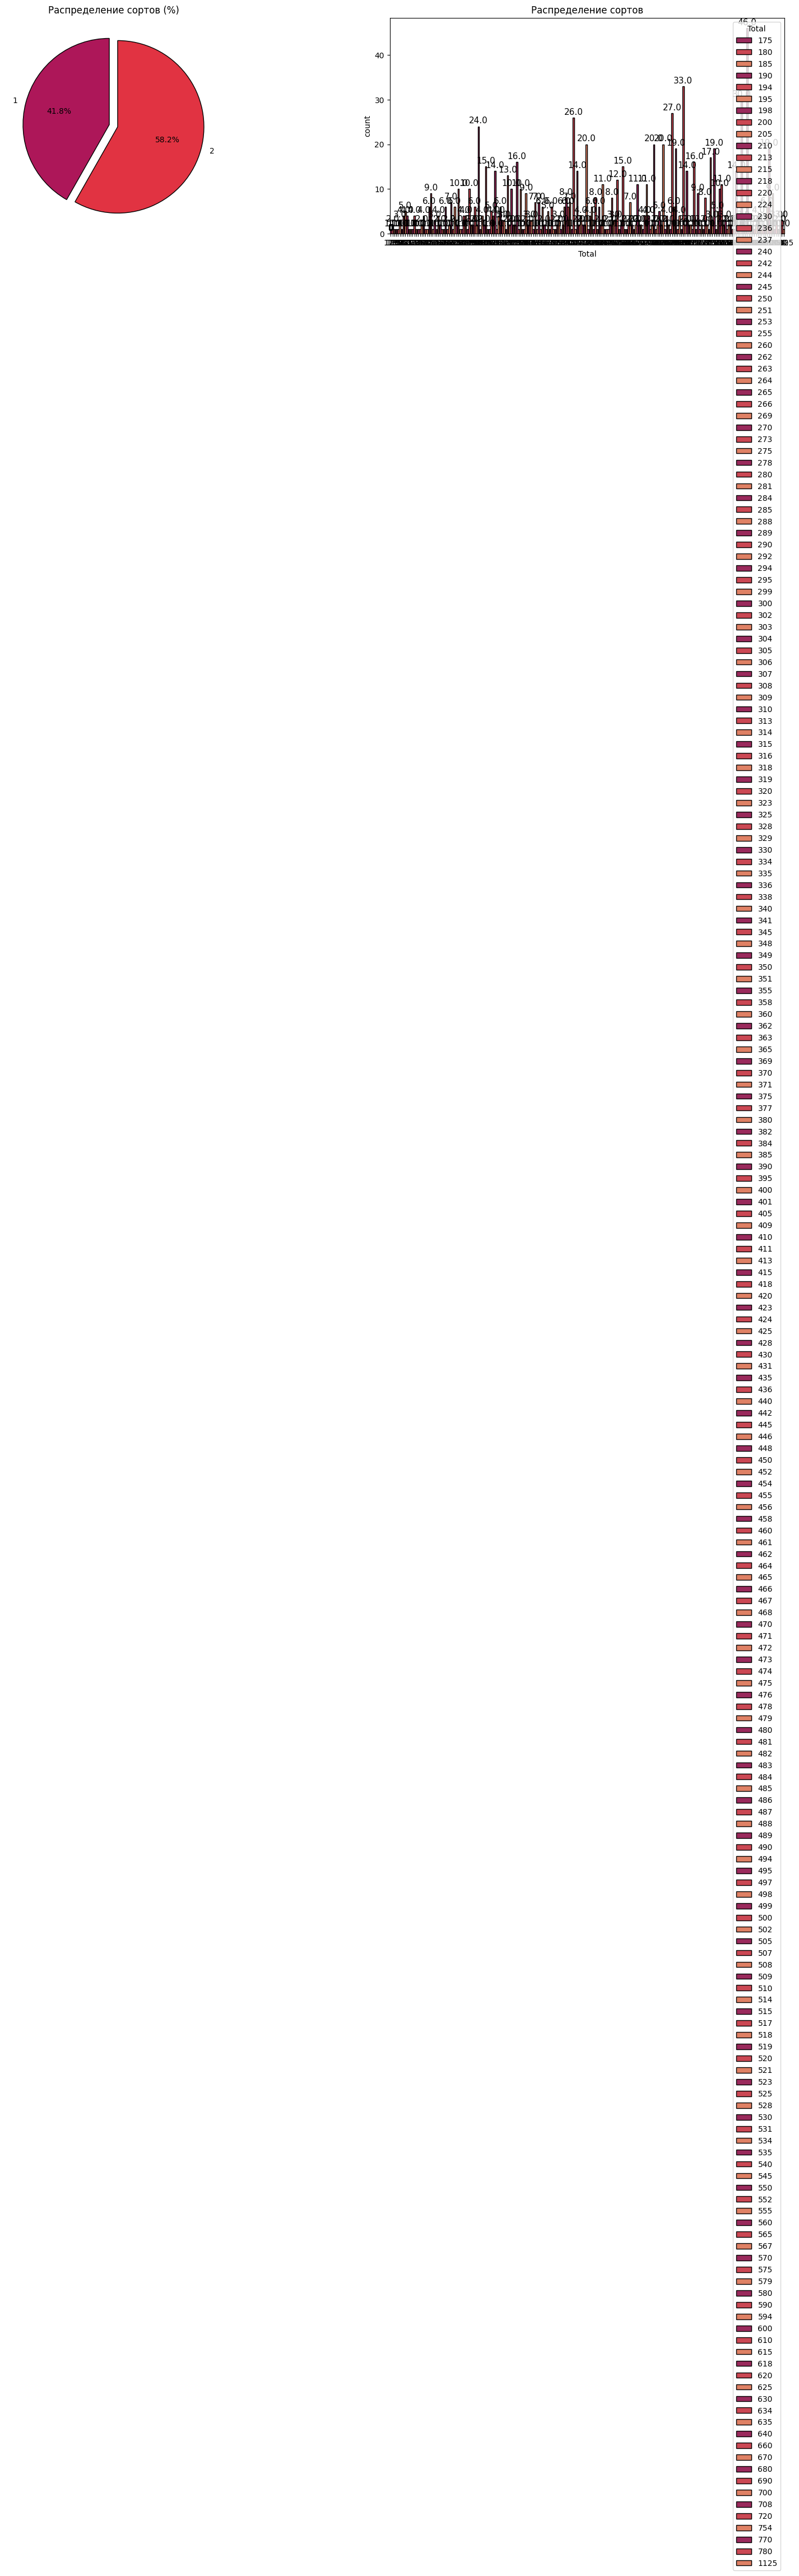

In [31]:
l = list(df['Total'].value_counts())
sumLenn = sum(l)
# proc = [l[1] / sumLenn * 100, l[0] / sumLenn * 100, l[2] / sumLenn * 100]
proc = [l[1] / sumLenn * 100, l[0] / sumLenn * 100]
colors1 = sns.color_palette("rocket")[2:5]


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
plt.subplot(1, 2, 1)
# plt.pie(proc, labels = ['1', '2', '3'], 
plt.pie(proc, labels = ['1', '2'],
        autopct = '%1.1f%%', 
        startangle = 90,
        # explode = (0.05,0.05, 0.05), 
        explode = (0.05, 0.05), 
        colors = colors1, 
        wedgeprops = {'edgecolor' : 'black','antialiased' : True})
plt.title('Распределение сортов (%)')

plt.subplot(1, 2, 2)
ax = sns.countplot(x = df['Total'], 
                   hue = df['Total'], 
                   palette = colors1, 
                   edgecolor = "black" )
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.7,\
            rect.get_height(), horizontalalignment='center', fontsize = 11)
plt.title('Распределение сортов');

In [32]:
rs_k = rand_score(kmeans.labels_, y) 
rs_ward = rand_score(pred_ward, y)
rs_sp = rand_score(pred_sp, y)

print('\nK-Means')
print('_'* 45 + '\n')
print(" rand_score = {} \n\n {} из 1045 предсказано верно \n\n\n\n".format(rs_k, rs_k * 1045))


print('Agglomerative Clustering')
print('_'* 45 + '\n')
print(" rand_score = {} \n\n {} из 1045 предсказано верно \n\n\n\n".format(rs_ward, rs_ward * 1045))


print('Spectral Clustering')
print('_'* 45 + '\n')
print(" rand_score = {} \n\n {} из 1045 предсказано верно \n".format(rs_sp, rs_sp * 1045))


K-Means
_____________________________________________

 rand_score = 0.8854593914266676 

 925.3050640408677 из 1045 предсказано верно 




Agglomerative Clustering
_____________________________________________

 rand_score = 0.48234989264825645 

 504.05563781742796 из 1045 предсказано верно 




Spectral Clustering
_____________________________________________

 rand_score = 0.49529133042126305 

 517.5794402902198 из 1045 предсказано верно 



##### <h1 id="aa" align="center" style="color:black;background:#ffcc01;padding:18px;border-radius:50px"> КЛАССИФИКАЦИЯ ПОКЕМОНОВ </h1> 

In [33]:
results = {}

In [34]:
df_num = df.select_dtypes(include = ['float64', 'int64'])

In [35]:
X = df_num.drop(columns=["Attack"])
y = df_num["Attack"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
gradientBoosting = GradientBoostingRegressor(random_state=42)
gradientBoosting.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [38]:
y_pred = gradientBoosting.predict(X_test)

In [39]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
results["Gradient Boosting"] = {"MAE": mae, "R^2": r2}

In [40]:
randomForest = RandomForestRegressor(random_state=42, n_estimators=100)
randomForest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [41]:
y_pred = randomForest.predict(X_test)

In [42]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
results["Random Forest"] = {"MAE": mae, "R^2": r2}

In [43]:
histGradientBoosting = HistGradientBoostingRegressor(random_state=42)
histGradientBoosting.fit(X_train, y_train)

HistGradientBoostingRegressor(random_state=42)

In [44]:
y_pred = histGradientBoosting.predict(X_test)

In [45]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
results["Hist Gradient Boosting"] = {"MAE": mae, "R^2": r2}

In [46]:
print('\nGradient Boosting')
print('_'* 45 + '\n')
print(" MAE = {} \n R^2 = {} \n {} из 1045 предсказано правильно \n\n".format(results['Gradient Boosting']['MAE'], results['Gradient Boosting']['R^2'], results['Gradient Boosting']['R^2'] * 1045))


print('\nRandom Forest')
print('_'* 45 + '\n')
print(" MAE = {} \n R^2 = {} \n {} из 1045 предсказано правильно \n\n".format(results['Random Forest']['MAE'], results['Random Forest']['R^2'], results['Random Forest']['R^2'] * 1045))

print('\nHist Gradient Boosting')
print('_'* 45 + '\n')
print(" MAE = {} \n R^2 = {} \n {} из 1045 предсказано правильно \n\n".format(results['Hist Gradient Boosting']['MAE'], results['Hist Gradient Boosting']['R^2'], results['Hist Gradient Boosting']['R^2'] * 1045))


Gradient Boosting
_____________________________________________

 MAE = 12.866898645104657 
 R^2 = 0.7491640828340491 
 782.8764665615813 из 1045 предсказано правильно 



Random Forest
_____________________________________________

 MAE = 12.20673076923077 
 R^2 = 0.7533504461290769 
 787.2512162048853 из 1045 предсказано правильно 



Hist Gradient Boosting
_____________________________________________

 MAE = 9.499861402802711 
 R^2 = 0.8339406346933054 
 871.4679632545041 из 1045 предсказано правильно 




### Вывод
##### Датасет не имел каких либо аномалий или пропущенных данных. Самой лучшей кластеризацией оказалась K-Means со значение 0.86 (86%, 901 из 1045 предсказано правильно).
##### Самой лучшей классификацией был Hist Gradient Boosting со значением 0.83 (83%, 871 из 1045 предсказано правильно).